In [12]:
import altair as alt
alt.renderers.enable('notebook')
import pandas as pd
import numpy as np
import glob
import datetime

### Load and join data

In [32]:
def load_data(
    pattern='../output-data/*yearly.csv',
    cols=['coin', 'date', 'total_supply', 'total_supply_pct']
    ):
    files = glob.glob(pattern)
    print("\n".join(files))
    df = pd.concat((
        pd.read_csv(f) for f in files
    ), sort=True)
    
    if 'ETH' in df.coin.unique():
        eth_mask = df.coin == 'ETH'
        df.loc[eth_mask, 'total_supply'] = df.loc[eth_mask, 'current_plan']
        df.loc[eth_mask, 'total_supply_pct'] = df.loc[eth_mask, 'current_plan_pct']

    if 'ETC' in df.coin.unique():
        etc_mask = df.coin == 'ETC'
        df.loc[etc_mask, 'total_supply'] = df.loc[etc_mask, 'etc']
        df.loc[etc_mask, 'total_supply_pct'] = df.loc[etc_mask, 'etc_pct']
        
    if 'SMH' in df.coin.unique():
        smh_mask = df.coin == 'SMH'
        df.loc[smh_mask, 'total_supply'] = df.loc[smh_mask, 'plan1']
        df.loc[smh_mask, 'total_supply_pct'] = df.loc[smh_mask, 'plan1_pct']
        
    df.date = pd.to_datetime(df['date'])
    df['total_supply'] = df.total_supply_pct / 100
    
    return df[cols]

In [33]:
df = load_data()

../output-data/BTC_yearly.csv
../output-data/TRX_yearly.csv
../output-data/ETC_yearly.csv
../output-data/GAS_yearly.csv
../output-data/XRP_yearly.csv
../output-data/EOS_yearly.csv
../output-data/LTC_yearly.csv
../output-data/NEO_yearly.csv
../output-data/IOTA_yearly.csv
../output-data/XMR_yearly.csv
../output-data/DOGE_yearly.csv
../output-data/BTS_yearly.csv
../output-data/NANO_yearly.csv
../output-data/DASH_yearly.csv
../output-data/XLM_yearly.csv
../output-data/ETH_yearly.csv
../output-data/XEM_yearly.csv
../output-data/SMH_yearly.csv
../output-data/ZEC_yearly.csv


### Unstack and dump to file

In [34]:
def dump_unstacked(df, f_path):
    '''
    Unstack coins, sort by date, interpolate
    and dump to file.
    '''
    df_unstacked = (df[['date', 'coin', 'total_supply_pct']]
                    .set_index(['date', 'coin'])
                    .sort_index()
                    .unstack('coin')
                    .interpolate(method='linear')
                    )
    df_unstacked.columns = df_unstacked.columns.get_level_values(1)
    df_unstacked.to_csv(f_path)

dump_unstacked(df, '../output-data/relative_coin_supply_pct_estimates.csv')

### Plot data

In [35]:
df.groupby('coin').head(1)

,coin,date,total_supply,total_supply_pct
0,BTC,2009-01-01,2.380952e-06,0.000238
0,TRX,2017-09-01,4.123513e-01,41.235132
0,ETC,2015-07-01,3.353003e-01,33.530034
0,GAS,2017-07-01,7.000000e-08,0.000007
0,XRP,2018-12-01,4.360416e-01,43.604156
0,EOS,2017-07-01,9.000000e-01,90.000000
0,LTC,2011-10-01,5.945586e-07,0.000059
0,NEO,2014-02-01,5.000000e-01,50.000000
0,IOTA,2017-06-01,1.000000e+00,100.000000
0,XMR,2014-04-01,9.365279e-04,0.093653


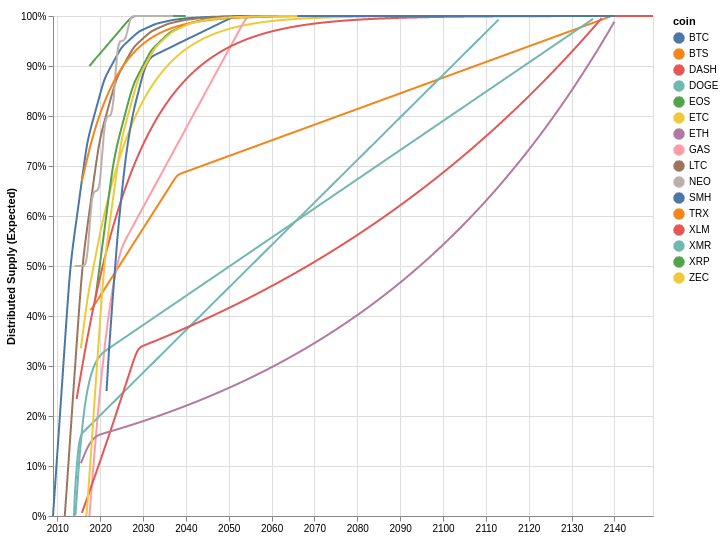

In [36]:
source_mask = df.coin.apply(lambda x: x not in ('IOTA', 'XEM', 'NANO'))
source = df[source_mask]
x = 'date'
y = 'total_supply'
y_label = 'total_supply_pct'
category = 'coin'

def multi_line_plot(source, x, y, category, size=(600, 500)):
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                            fields=[x], empty='none')

    line = alt.Chart().mark_line(interpolate='basis').encode(
        x=alt.X(x, axis=alt.Axis(title='')),
        y=alt.Y(y, axis=alt.Axis(format='%', title='Distributed Supply (Expected)')),
        color=category,
    )

    selectors = alt.Chart().mark_point().encode(
        x=x,
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    points = line.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    text = line.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'label:N', alt.value(' '))
    ).transform_calculate(label='format(datum.{},".0f") + "% " + datum.{}'.format(y_label, category))

    rules = alt.Chart().mark_rule(color='gray').encode(
        x=x,
    ).transform_filter(
        nearest
    )

    chart = alt.layer(line, selectors, points, rules, text,
                      data=source, width=size[0], height=size[1])

    return chart

chart_1 = multi_line_plot(source, x, y, category)
chart_1

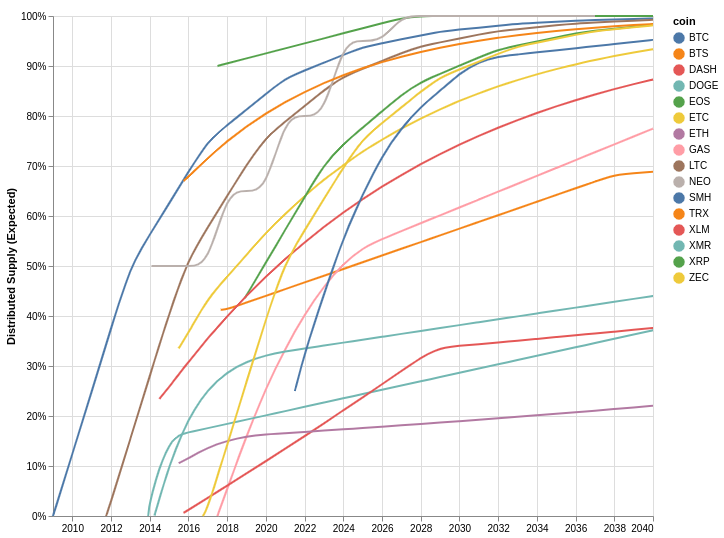

In [37]:
mask = source.date <= datetime.datetime(2040, 1, 1)
chart_2 = multi_line_plot(source[mask], x, y, category)
chart_2

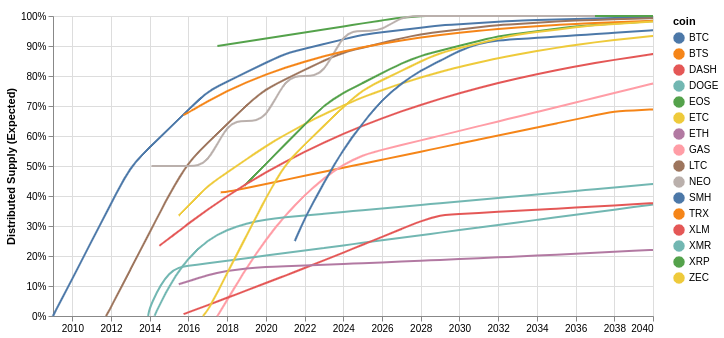

In [38]:
mask = source.date <= datetime.datetime(2040, 1, 1)
chart_3 = multi_line_plot(source[mask], x, y, category, size=(600, 300))
chart_3

In [39]:
with open('../charts/relative_coin_supply_pct_estimates.png', 'wb') as f:
    chart_1.save(f, format='png', scale_factor=3.0)
    
with open('../charts/relative_coin_supply_pct_estimates_zoom.png', 'wb') as f:
    chart_2.save(f, format='png', scale_factor=3.0)
    
with open('../charts/relative_coin_supply_pct_estimates_cover.png', 'wb') as f:
    chart_3.save(f, format='png', scale_factor=3.0)

WARN Infinite extent for field "date": [Infinity, -Infinity]
WARN Infinite extent for field "date": [Infinity, -Infinity]
WARN Infinite extent for field "date": [Infinity, -Infinity]


In [40]:
with open('../charts/relative_coin_supply_pct_estimates.html', 'w') as f:
    chart_1.save(f, format='html')
    
with open('../charts/relative_coin_supply_pct_estimates_zoom.html', 'w') as f:
    chart_2.save(f, format='html')

In [41]:
with open('../charts/relative_coin_supply_pct_estimates.json', 'w') as f:
    chart_1.save(f, format='json')
    
with open('../charts/relative_coin_supply_pct_estimates_zoom.json', 'w') as f:
    chart_2.save(f, format='json') 